In [ ]:
#| default_exp interpolation

## Cartographic interpolation 

> Project volumetric image onto a surface and map it to 2d using UV map.

This module is the "heart" of `blender_tissue_cartography` - the rest is just add ons. We illustrate it with a basic example of tissue cartography workflow.

In this notebook, we go through a basic example of tissue cartography - extracting the mildly curved surface of an epithelium from a confocal $z$-stack. This example data is taken from [Lye et al. 2024](https://doi.org/10.1371/journal.pbio.3002611), available at https://www.ebi.ac.uk/biostudies/studies/S-BIAD1271.

We introduce the functions of our python module for cartographic interpolation one by one.

In [ ]:
#| export

import numpy as np
from skimage import transform
from scipy import interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt
from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import mesh as tcmesh
from blender_tissue_cartography import remesh as tcremesh

import warnings
import igl

In [ ]:
import os
from scipy import ndimage

In [ ]:
# Only run this if you have installed pymeshlab
import pymeshlab
from blender_tissue_cartography import remesh_pymeshlab as tcremesh_pymeshlab

Unable to load the following plugins:

	libio_e57.so: libio_e57.so does not seem to be a Qt Plugin.

Cannot load library /home/nikolas/Programs/miniconda3/envs/blender-tissue-cartography/lib/python3.11/site-packages/pymeshlab/lib/plugins/libio_e57.so: (/lib/x86_64-linux-gnu/libp11-kit.so.0: undefined symbol: ffi_type_pointer, version LIBFFI_BASE_7.0)



### Important conventions
 
1. Image axis 0 is always the channel. All other axes are not permuted
2. Mesh coordinates are always saved in microns. 
3. The UV map (the map of our surface mesh to a cartographic plane) always maps into the unit square, $u\in[0,1], \; v\in[0,1]$. All of our projections will be square images (with transparent regions for parts of the UV square not covered by the unwrapped mesh)

## Load and subsample data for segmentation

**Data description** myosin + membrane ventral view of Drosophila embryo during germband extension, from Lye et al. 2024.

We begin by creating a directory for our project where we'll save all related files (and normally, the jupyter notebook used to generate them!).

Let's load the dataset. We then enter the relevant metadata - the filename, resolution in microns, and how much we want to subsample for segmentation purposes.

In [ ]:
metadata_dict = {'filename': 'datasets/basics_example/basics_example',
                 'resolution_in_microns': (1, 0.36, 0.36), # you can typically get this from the .tif metadata
                 'subsampling_factors': (1, 1/3, 1/3)}

In [ ]:
metadata_dict['subsampling_factors']

(1, 0.3333333333333333, 0.3333333333333333)

In [ ]:
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))
print("image shape:", image.shape) # image shape - spatial axes are in z-x-y order

image shape: (2, 26, 454, 511)


In [ ]:
subsampled_image = tcio.subsample_image(image, metadata_dict['subsampling_factors'],
                                        use_block_averaging_if_possible=False)
print("subsampled image shape:", subsampled_image.shape)

subsampled image shape: (2, 26, 151, 170)


## Create 3d segmentation

Now create a 3d segmentation, in this case using ilatik. We use [ilastik binary pixel classification](https://www.ilastik.org/documentation/pixelclassification/pixelclassification). We could post-process the ilastik output here, for example using morphsnakes. We then load the segmentation back into the jupyter notebook.

Attention: when importing the `.h5` into ilastik, make sure the dimension order is correct! In this case, `CZYX` (where `C`=channel), for both export and import. You can include this metadata in the `.h5`:

In [ ]:
# We now save the subsampled image as a .h5 file for input into ilastik for segmentation

tcio.write_h5(f"{metadata_dict['filename']}_subsampled.h5", subsampled_image, axis_order='CZYX')

In [ ]:
# After creating an ilastik project, training the model, and exporting the probabilities, we load the segmentation

segmentation = tcio.read_h5(f"{metadata_dict['filename']}_subsampled-image_Probabilities.h5")
segmentation = segmentation[0] # Select the first channel of the segmentation - it's the probability a pixel
                               # is part of the sample
print("segmentation shape:", segmentation.shape)

segmentation shape: (26, 151, 170)


<matplotlib.image.AxesImage>

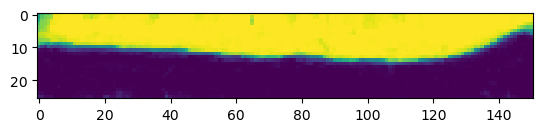

In [ ]:
# look at the segmentation in a cross-section

plt.imshow(segmentation[:,:,50], vmin=0, vmax=1)

## Meshing

We convert the segmentation into a triangular mesh using the marching cubes method and save the mesh. We save all meshes as wavefront `.obj` files (see [wikipedia](https://en.wikipedia.org/wiki/Wavefront_.obj_file)). In Python, we represent missing entries (such as a vertex that doesn't have a normal by `np.nan`.

**Important convention** For sanity's sake, we will always store all mesh coordinates in microns. This means rescaling appropriately after calculating the mesh from the 3d segmentation.

In [ ]:
# Now we create a 3d mesh using the marching cubes method

vertices, faces = tcremesh.marching_cubes(segmentation, isovalue=0.5, sigma_smoothing=3)

# EXTREMELY IMPORTANT - we now rescale the vertex coordinates so that they are in microns.
vertices_in_microns = vertices * (np.array(metadata_dict['resolution_in_microns'])
                                 /np.array(metadata_dict['subsampling_factors']))

mesh = tcmesh.ObjMesh(vertices_in_microns, faces)
mesh.name = "basics_example_mesh_marching_cubes"
mesh.write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")

### Optional - mesh compression using igl

The mesh returned by the marching cubes method is normally much denser than necessary. You can automatically reduce its size here in Python, or later in Blender.

In [ ]:
mesh_compressed = tcremesh.qslim(mesh, max_n_faces=int(faces.shape[0]/2))
mesh_compressed.name = "basics_example_mesh_marching_cubes_compressed"
mesh_compressed.write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes_compressed.obj")

### Optional - improve mesh quality using MeshLab

We can remesh the output of the marching cubes algorithm to obtain an improved mesh, i.e. with more uniform triangle shapes. In this example, we first remesh to make the mesh more uniform.
You can also try this out in the MeshLab GUI and export your workflow as a Python script. Be careful not to move the mesh or it will mess up the correspondence with the pixel coordinates!

See [List of MeshLab filers](https://pymeshlab.readthedocs.io/en/latest/filter_list.html)

In [ ]:
mesh_remeshed = tcremesh_pymeshlab.remesh_pymeshlab(mesh)
mesh_remeshed.write_obj(f"{metadata_dict['filename']}_mesh_remeshed.obj")

To check all went well, let's overlay the mesh coordinates over a cross-section of the image. To do so, we first select the vertices whose positions correspond to the image slice, and then correctly rescale coordinates from microns to pixel coordinates.

In [ ]:
#| export

def get_cross_section_vertices_normals(slice_axis, slice_index, image, mesh, resolution,
                                       get_normals=True, width=3):
    """
    Get mesh vertices and normals for diagnostic cross-section overlay plots.
    
    Usage example:
        slice_image, slice_vertices, slice_normals = get_cross_section_vertices_normals(1, 100,
                                    image, mesh, metadata_dict["resolution_in_microns"])
        plt.scatter(*slice_vertices.T, s=5, c="tab:red")
        plt.quiver(*slice_vertices.T, *slice_normals.T, color="tab:red")
        plt.imshow(slice_image[0], vmax=10000, origin="lower")
    
    Note: `origin="lower"` in plt.imshow() is essential for a correctly oriented plot in Python!!
        
    Parameters
    ----------
    image : 4d np.ndarray of shape (channels, n_x, n_y, n_z)
        Image. Axis 0 is channel
    mesh : tcmesh.ObjMesh
        Mesh
    resolution : int, default 256
        Resolution in pixels/micron.
    slice_index : int
        Index along the sliced axis
    slice_axis : int, 0,1,2
        Axis along which to slice image array
    get_normals : bool, default True
        Whether to return normals also
    width : float
        Width of slice for vertex selection, in microns
    
    Returns
    -------
    slice_image : 3d np.array 
        Slice of image. Axis 0 is channel
    slice_vertices : 2d  np.array
        Projected vertices in the slice. The second axis is the coordinate one.
    slice_normals : 2d  np.array (..., 2)
        Projected normals in slice. The second axis is the coordinate one.

    """
    slice_image = image.take(indices=slice_index, axis=slice_axis+1).transpose((0,2,1))
    slice_coordinate = slice_index*resolution[slice_axis]
    if get_normals:
        slice_mask = np.abs(mesh.vertices[:,slice_axis]-slice_coordinate) < width
        slice_vertices = mesh.vertices[slice_mask] / resolution
        slice_vertices = slice_vertices.take(indices=[i for i in range(3) if i != slice_axis], axis=1)
        slice_normals = mesh.normals[slice_mask] / resolution
        slice_normals = slice_normals.take(indices=[i for i in range(3) if i != slice_axis], axis=1)
        return slice_image, slice_vertices, slice_normals
    slice_mask = np.abs(mesh.vertices[:,slice_axis]-slice_coordinate) < width
    slice_vertices = mesh.vertices[slice_mask] / resolution
    slice_vertices = slice_vertices.take(indices=[i for i in range(3) if i != slice_axis], axis=1)
    return slice_image, slice_vertices

In [ ]:
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))
mesh = tcmesh.ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_remeshed.obj")

In [ ]:
slice_image, slice_vertices = get_cross_section_vertices_normals(2, 200,
                                image, mesh, metadata_dict["resolution_in_microns"], get_normals=False)

<matplotlib.image.AxesImage>

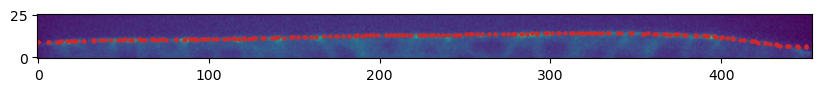

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.scatter(*slice_vertices[:,::-1].T, s=5, c="tab:red")
plt.imshow(slice_image[0].T, origin="lower")

## UV-mapping in blender

We now switch to blender and create a new empty project, which we will call `f"{metadata_dict['filename']}.blend"`. We import the mesh just generated (File->Import).

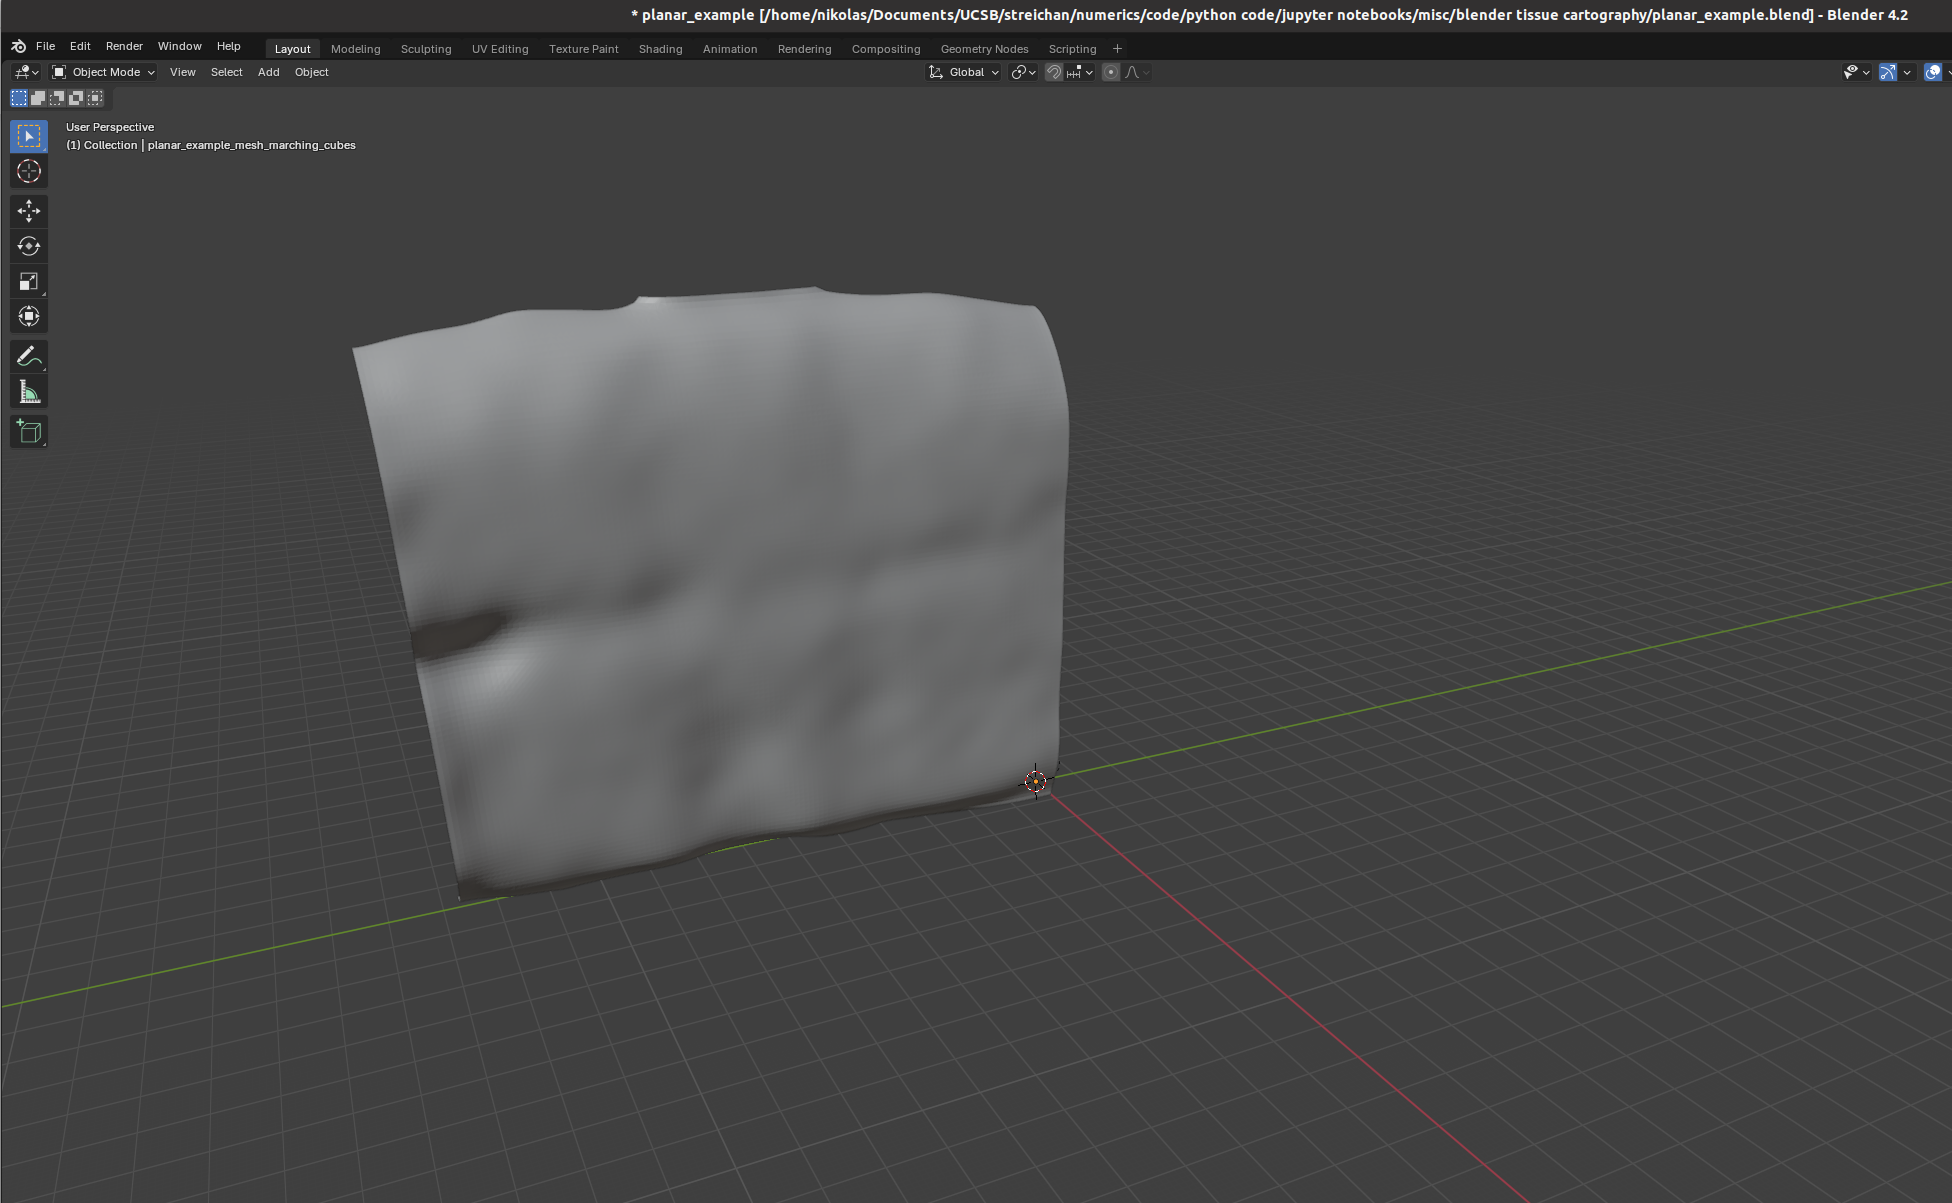

I recommend using the "object" tab (orange square on the right toolbar) to lock mesh position and rotation so we don't accidentally move it.

Let's try to move forward and get a UV map of the mesh. To do so, we go to the "UV Editing" tab on the top toolbar, and press "3" then "A" to select all faces ("1" selects vertices, "2" edges, and "3" faces). Click "UV->unwrap" on the top panel.
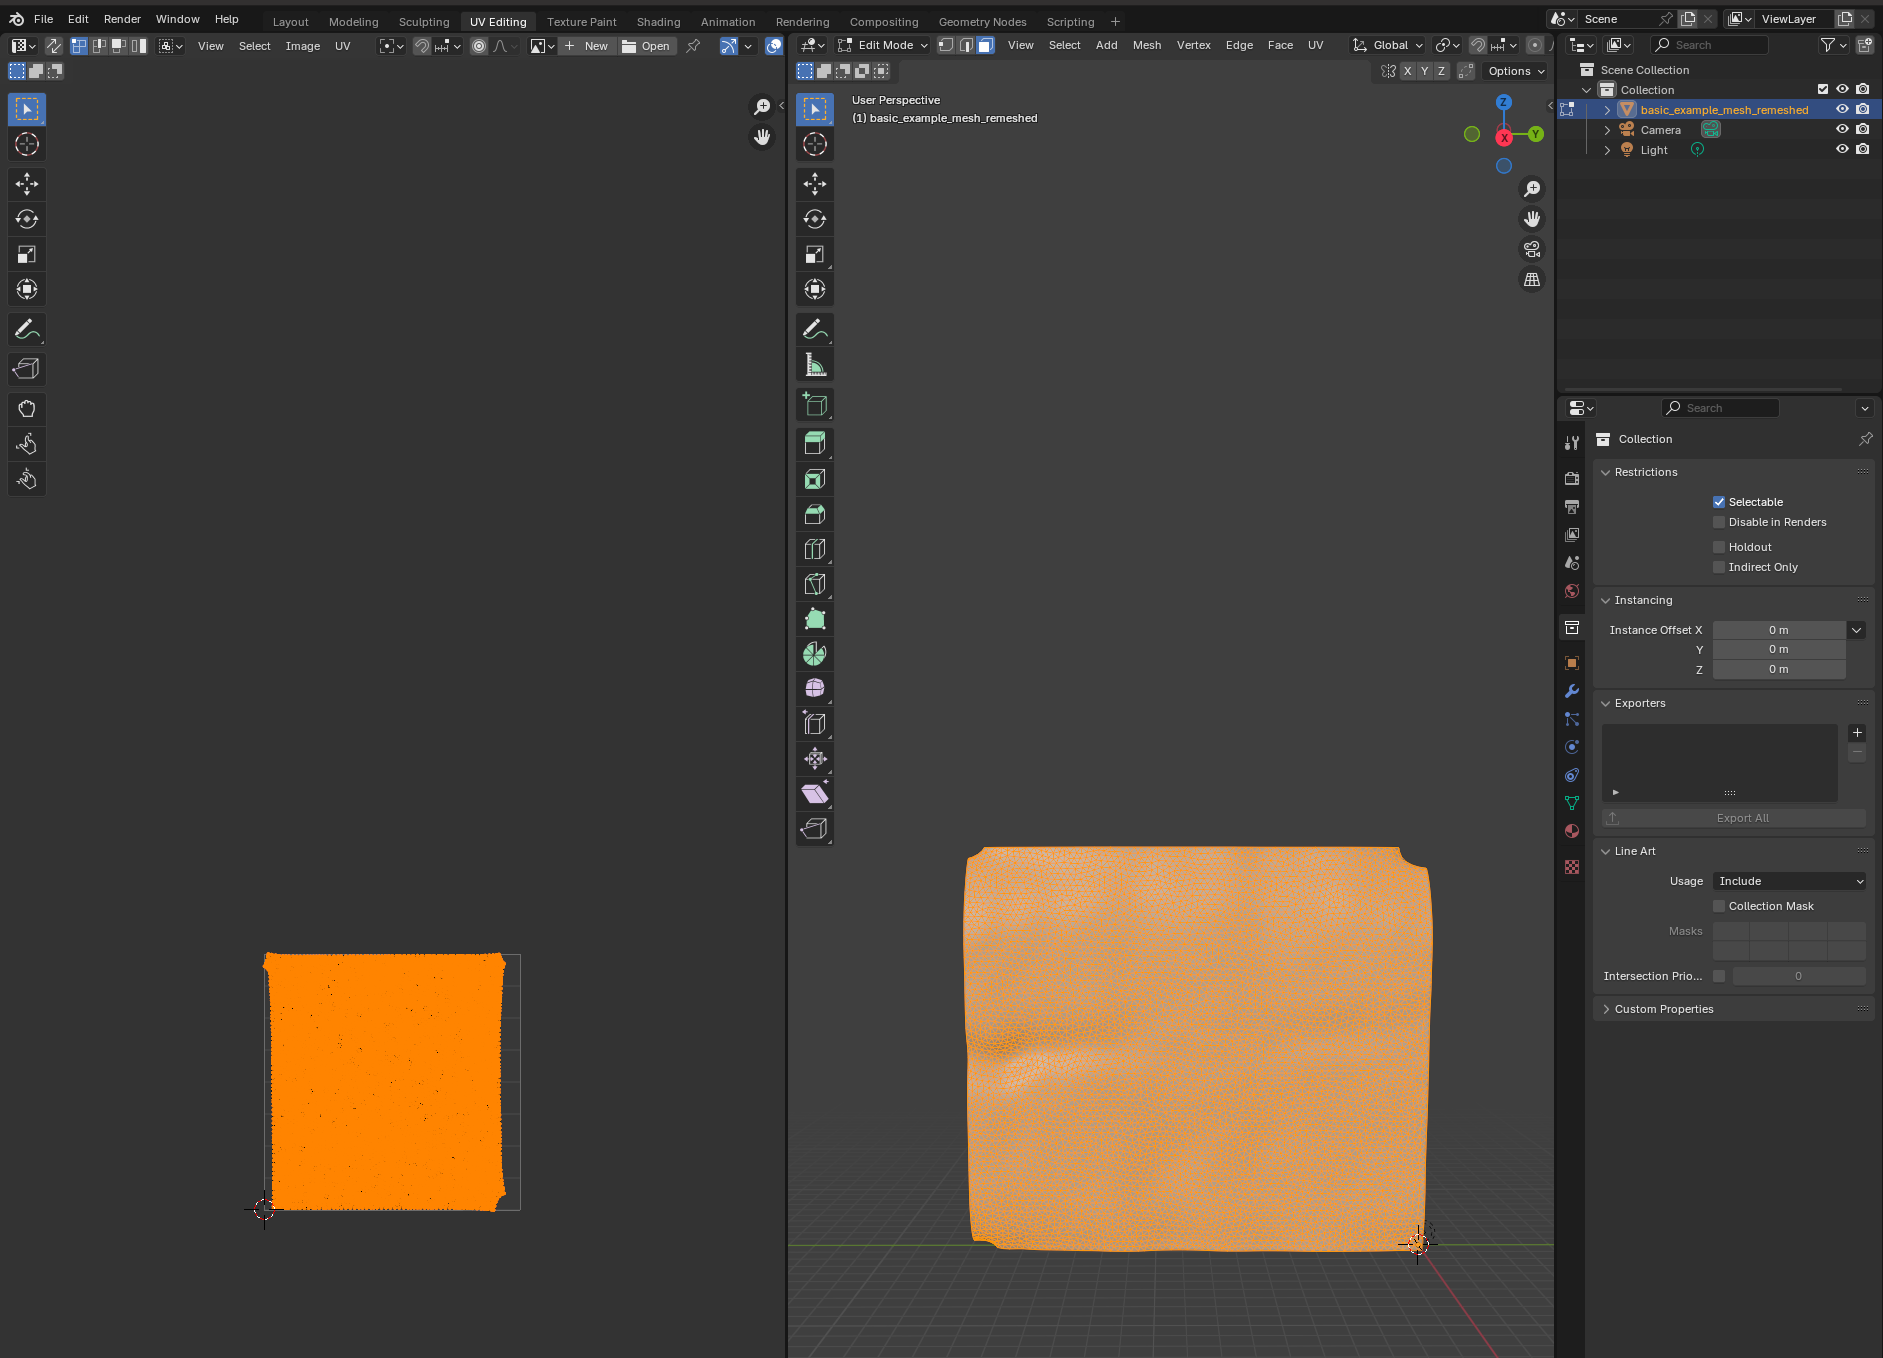
For more complicated meshes (e.g. a sphere), we will need to use extra steps, e.g. define seams.

### Blender export

We then click on "File->Export" and save as `.obj` with UV and normals:

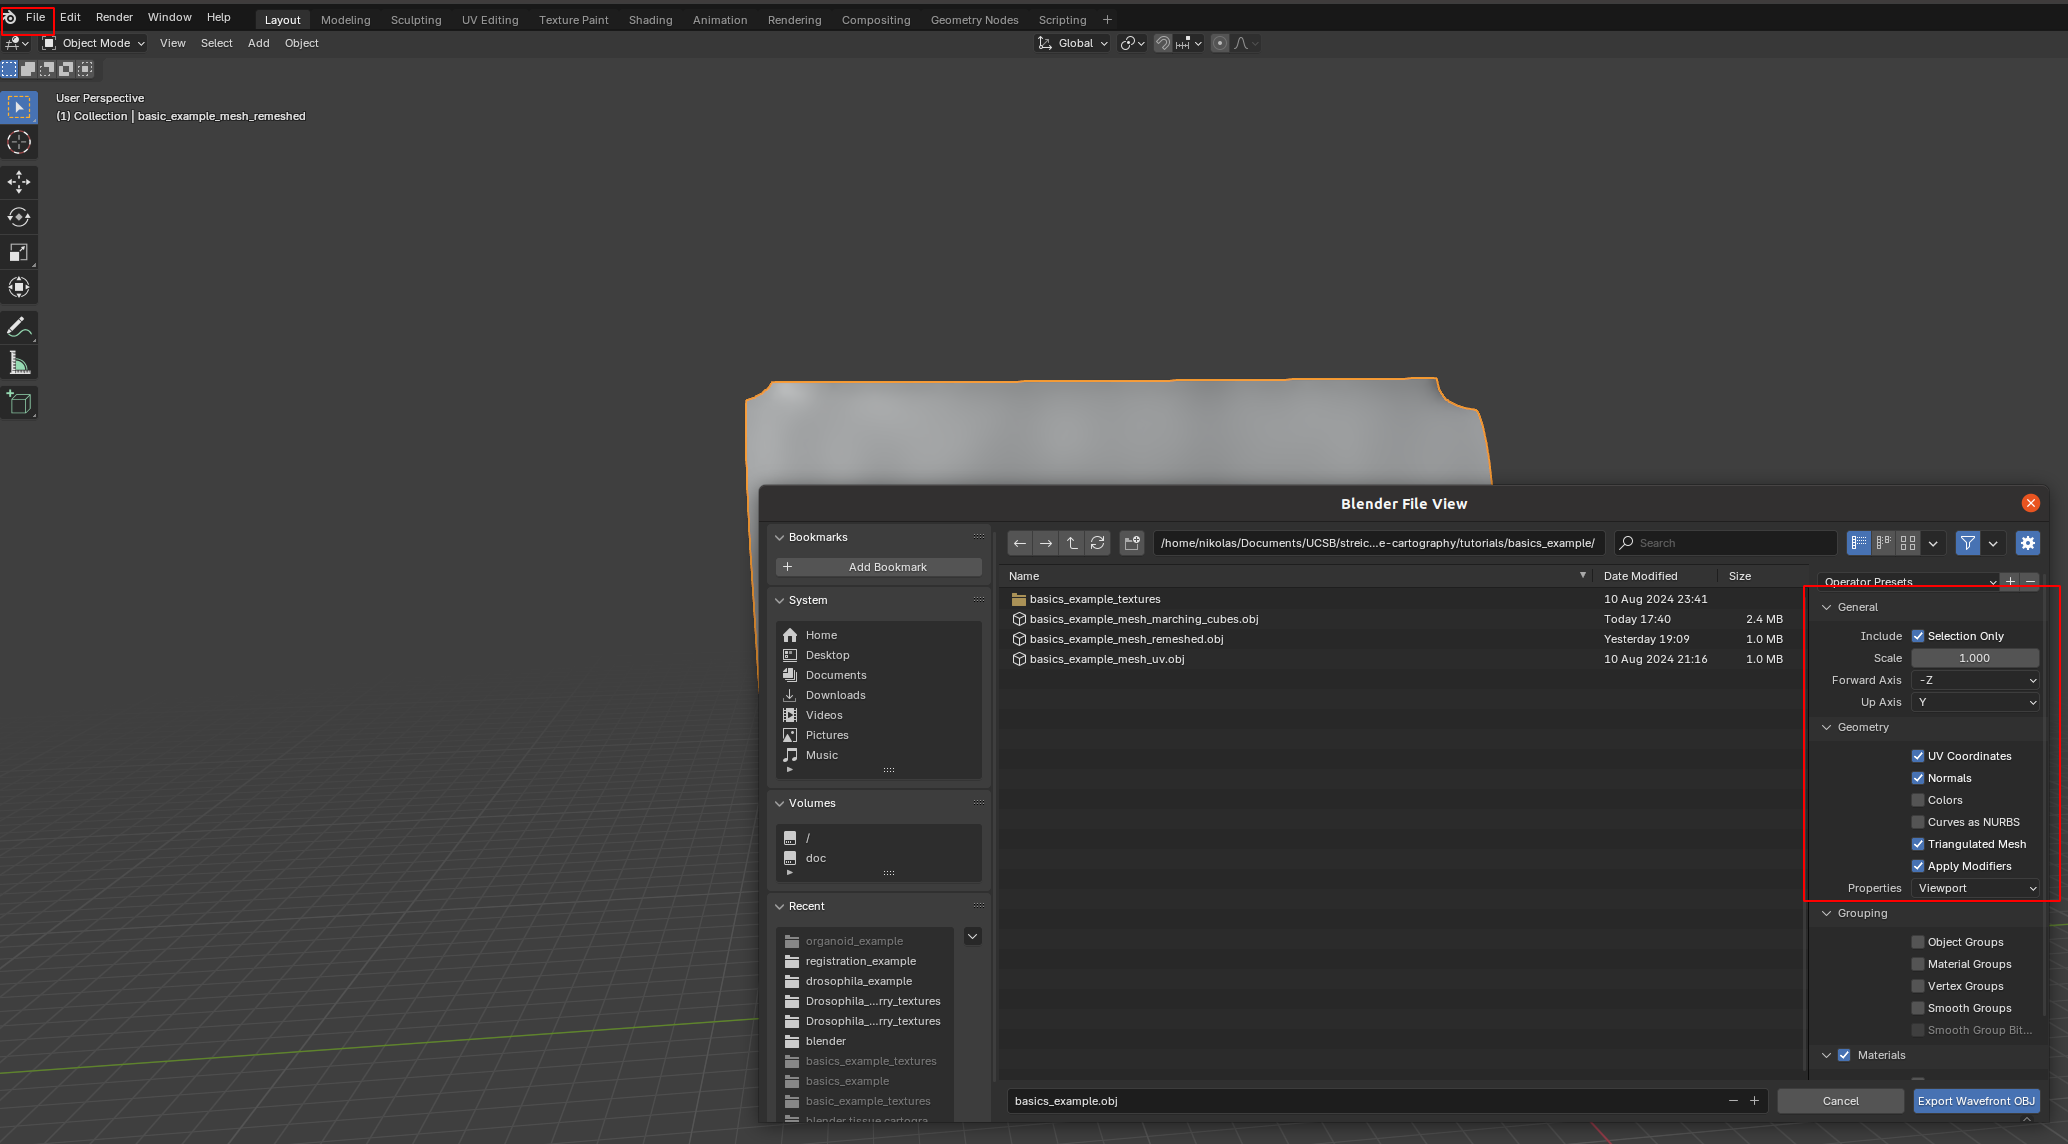

A few things are important:
- Always include UV and normals. Otherwise, cartographic projection will fail!
- Only export selected items! With a more complicated blender project, you might end up exporting multiple meshes. This will trip up the cartographic projection algorithm.
- Export as triangulated mesh, since many of this package's tools for more advanced examples work best/only with triangular meshes. This option will subdivide any quads/polygons your mesh may have.

The new mesh file `f"{metadata_dict['filename']}_mesh_uv.obj"` now contains vertex normals and UV coordinates as `vn` and `vt` lines. Note - there can be more `vt`'s than `v`'s.

### Interpolation onto UV grid

We now read in the new `.obj` file to interpolate the image data onto the 3d mesh. We first introduce the functions necessary to do so, which are based on the `scipy.interpolation` module. Interpolation proceeds in two steps:
1. Interpolate the 3d coordinates from the mesh UV vertex positions onto the whole UV grid
2. Evaluate the image signal at the UV gridded 3d coordinates using a second interpolation step.
This ensures that the resolution of the cartographic projection is not limited by the resolution of the mesh.

The UV grid always covers the unit square $[0,1]^2$.

We first show how the interpolation works in a step-by-step manner, and then give a function that packages the whole process.

In [ ]:
# let's read in the mesh and match up the vertices, texture vertices, and normal vectors using the
# mesh connectivity information
mesh = tcmesh.ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_uv.obj")

# let's also load the image
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))

  o basic_example_mesh_remeshed


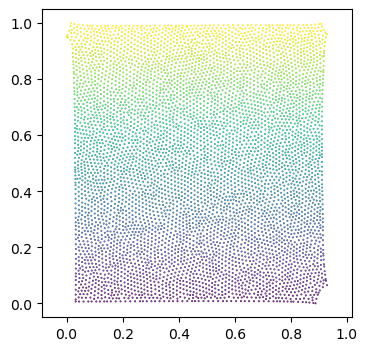

In [ ]:
# let's make a scatter plot of the mesh texture coordinates, and color it by 3d coordinate values

fig = plt.figure(figsize=(4,4),)
plt.scatter(*mesh.texture_vertices.T, s=0.2, c=mesh.vertices[mesh.get_vertex_to_texture_vertex_indices(),2])
plt.axis("equal");

It's not very noticeable in this example, but the part of the UV square covered by the unwrapped mesh can be extremely non-convex, in particular, if there are multiple patches (see notebook 3). Here is an example:
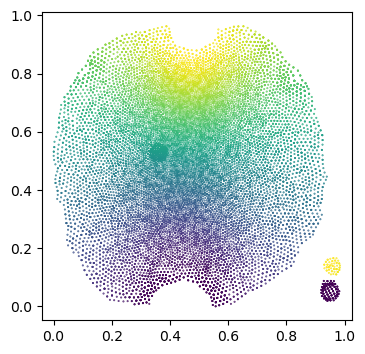

We set values outside the UV "islands"  to `np.nan`, since they are undefined. For non-triangular meshes, this requires a little hack to generate UV layout mask which delineates the part of the UV square covered by the unwrapped mesh. For triangular meshes, our barycentric interpolation method can take care of this issue by construction.

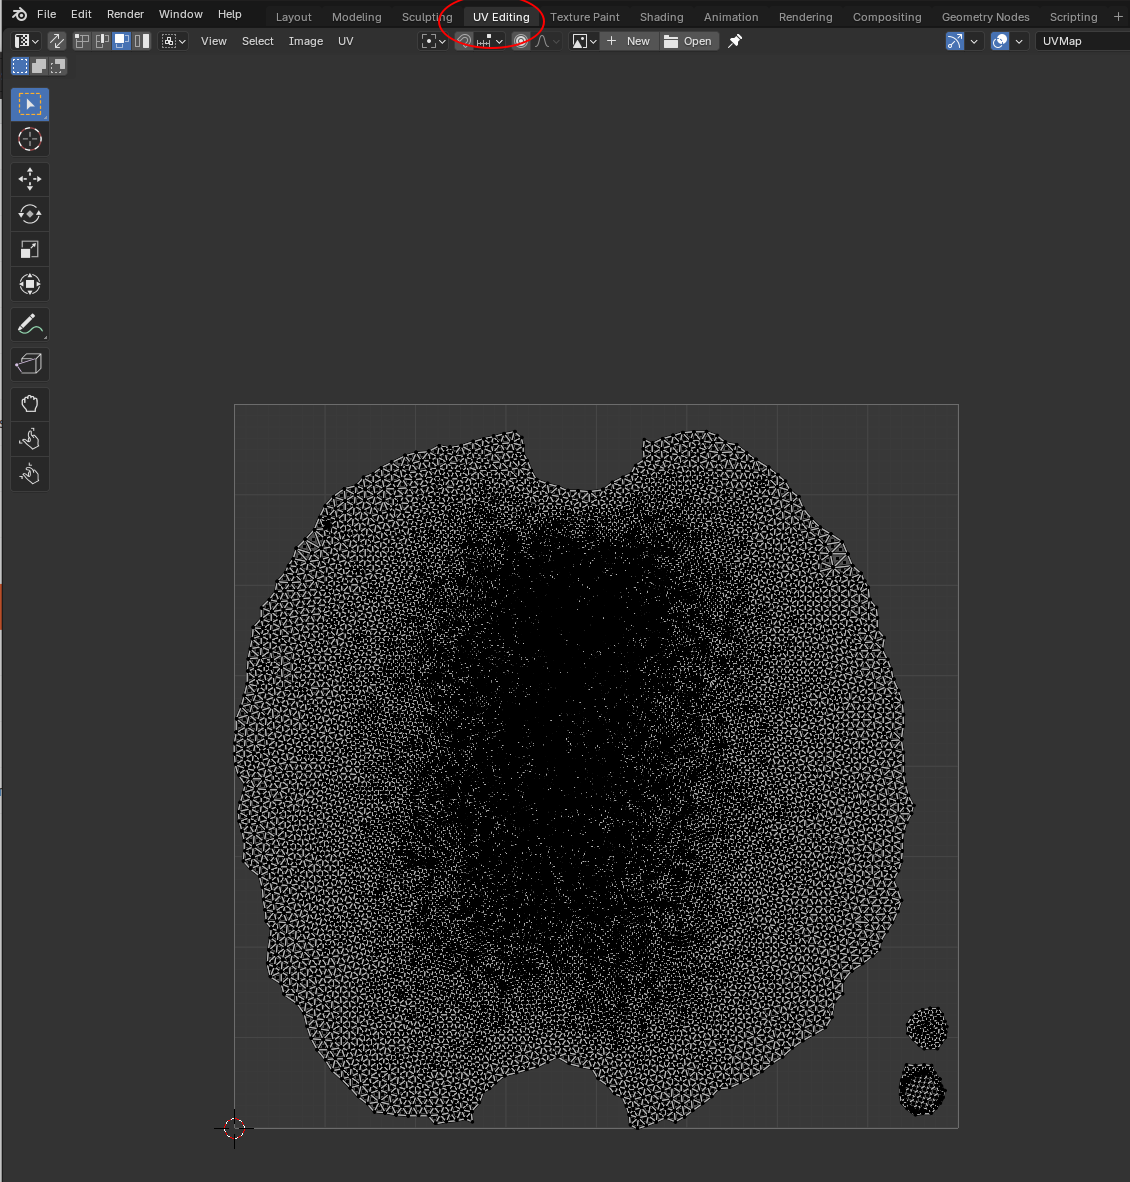

In [ ]:
#| export

def get_uv_layout_mask_mask(mesh: tcmesh.ObjMesh, uv_grid_steps=256):
    """
    Get a layout mask of the UV square: 1 where the UV square is covered by the unwrapped mesh, 0 outside.
    
    Based on matplotlib hack - this function works for non-triangular meshes.
    
    Parameters
    ----------
    mesh : tcmesh.ObjMesh
        Mesh with texture_vertices
    uv_grid_steps : int, default 256
        Size of UV grid. Determines resolution of result.
    
    Returns
    -------
    uv_mask : np.array of shape (uv_grid_steps, uv_grid_steps)
        Mask of the part of the UV square covered by the unwrapped mesh
    """
    assert mesh.texture_vertices is not None, "mesh must have texture vertices"
    fig = plt.figure(figsize=(1,1), dpi=uv_grid_steps, frameon=False)
    ax = plt.gca()
    if not mesh.is_triangular:
        valid_faces = [[v[1] for v in fc] for fc in mesh.faces if not np.isnan(list(tcmesh.flatten(fc))).any()]
        polygons = mpl.collections.PatchCollection([mpl.patches.Polygon([mesh.texture_vertices[v] for v in fc])
                                                    for fc in valid_faces], color="black")
        ax.add_collection(polygons)
    else:
        ax.tripcolor(*mesh.texture_vertices.T, mesh.texture_tris, np.ones((mesh.texture_vertices.shape[0],)),
                      cmap="binary", vmin=0, vmax=1)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    fig.canvas.draw()
    uv_mask = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).astype(float)
    uv_mask = 1-(uv_mask.reshape(fig.canvas.get_width_height()[::-1] + (4,))[...,0] > 0)
    plt.close()
    
    return uv_mask.astype(bool)

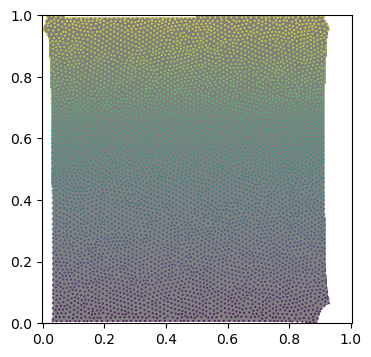

In [ ]:
uv_mask = get_uv_layout_mask_mask(mesh, uv_grid_steps=256)

fig = plt.figure(figsize=(4,4),)
plt.imshow(uv_mask, cmap='binary', alpha=0.5, extent=(0,1,0,1))
plt.scatter(*mesh.texture_vertices.T, s=0.2, c=mesh.vertices[mesh.get_vertex_to_texture_vertex_indices(),2])
plt.axis("equal");

### UV interpolation


In [ ]:
#| export

def interpolate_barycentric(points, vertices, faces, values, distance_threshold=np.inf):
    """
    Interpolate values defined on triangular mesh vertices onto points using barycentric interpolation.
    
    Can handle triangular meshes in both 3d and 2d. Points that do not lie on the triangular mesh
    are projected onto the closest point. Points more distant than the distance_threshold
    will be set to np.nan. The data defined on the triangular mesh must be defined per vertex
    and can have any number of axes (scalars, vectors, tensors, ...).
    
    This function can also be used to transfer values defined on one mesh to another mesh's
    vertices (if the two meshes are well-aligned in space).
    
    Parameters
    ----------
    points : np.array of shape (n_points, 2) or (n_points, 3)
        Points at which to evaluate
    vertices : np.array of shape (n_vertices, 2) or (n_vertices, 3)
        Mesh vertices
    faces : np.array of shape (n_faces, 3)
        Mesh triangles, indices into vertices array
    values : np.array of shape (n_vertices, ...)
        Values at mesh vertices. Can have any number of additional axes.
    distance_threshold : float
        Points with a squared distance to mesh > distance_threshold
        are set to np.nan
        
    Returns
    -------
    interpolated : np.array of shape (n_points, ...)
        Values at points.

    """
    assert vertices.shape[1] in [2,3], "Vertices must be 2d or 3d"
    if vertices.shape[1] == 2:
        vertices = np.pad(vertices, ((0,0), (0,1)))
        points = np.pad(points, ((0,0), (0,1)))

    # find the closest points on the mesh
    squared_distances, indices, points = igl.point_mesh_squared_distance(points, vertices, faces)
    hit_tris = faces[indices]
    # barycentric coordinates of the hit points. need small hack for data type issue 
    barycentric = igl.barycentric_coordinates_tri(np.array(points, order="C"),
                                                 *np.array(vertices[hit_tris].transpose((1,0,2)), order='C'))
    interpolated = np.einsum('vt,vt...->v...', barycentric, values[hit_tris])
    interpolated[squared_distances>distance_threshold] = np.nan
    return interpolated

In [ ]:
mesh = tcmesh.ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_uv.obj")

uv_grid_steps = 1024
u, v = 2*[np.linspace(0,1, uv_grid_steps),]
UV = np.stack(np.meshgrid(u, v), axis=-1).reshape((-1, 2))
 
interpolated = interpolate_barycentric(UV, mesh.texture_vertices, mesh.texture_tris,
                                       mesh.vertices[mesh.get_vertex_to_texture_vertex_indices()],
                                       distance_threshold=1e-5)
interpolated = interpolated.reshape((uv_grid_steps, uv_grid_steps, 3))[::-1]

# add flip check and warn!

  o basic_example_mesh_remeshed


<matplotlib.image.AxesImage>

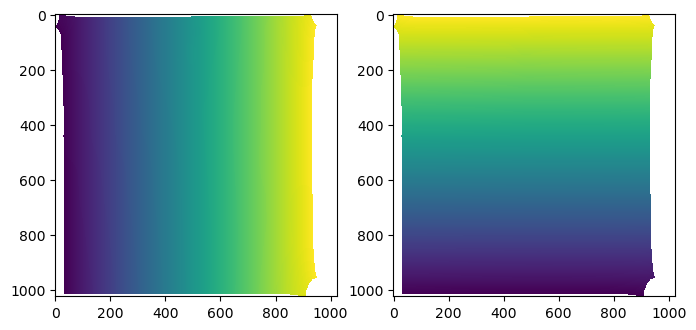

In [ ]:
# plot the interpolated positions
fig, (ax1, ax2) = plt.subplots(figsize=(8,4), ncols=2)

ax1.imshow(interpolated[...,1])
ax2.imshow(interpolated[...,2])

In [ ]:
#| export

def interpolate_per_vertex_field_to_UV(mesh, field, domain="per-vertex", uv_grid_steps=256, map_back=True,
                                       distance_threshold=1e-4, use_fallback=False):
    """
    Interpolate a field defined per-vertex into the UV square.
    
    The field can be defined per texture-vertex or per 3D-vertex. Make sure you use the right option!
    
    Assumes the map x,y,z -> u,v to be invertible. This is not guaranteed - you can create overlapping UV 
    coordinates in Blender.     Raises RuntimeWarning if any of the triangles in the UV map are flipped,
    indicating self-intersections.
    
    The provided UV coordinates will be mapped back to [0, 1]**2 if map_back is True.
    Else, coordinates outside [0,1] are ignored.
    
    Parameters
    ----------
    mesh : tcmesh.ObjMesh
        Input mesh with UV coordinates.
    field : np.array of shape (mesh.texture_vertices.shape[0],...)
        Input field. Can be an array with any number of axes (e.g. scalar or vector field).
    domain : "per-vertex" or "per-texture-vertex"
        Whether the field is defined per-vertex or per texture vertex.
    uv_grid_steps : int, default 256
        Size of UV grid. Determines resolution of result.
    map_back : bool, default True
        Map back the UV coordinates to [0,1]**2. Else, coordinates outside [0,1] are ignored.
    distance_threshold : float
        Points at a squared distance > distance_threshold in the UV square are considered
        "outside" the unwrapped mesh and are set to np.nan.
    use_fallback : bool or 'auto', default 'auto'
        Ignore mesh connectivity when interpolating. This is to be used as a fallback
        if you have a UV map with lots of flipped triangles (i.e. self-intersections).
        If 'auto', the fallback option is chosen automatically if there are any flipped 
        triangles.

    Returns
    -------
    interpolated : np.array of shape (uv_grid_steps, uv_grid_steps, ...)
        Field across [0,1]**2 UV grid, with a uniform step size. UV positions that don't
        correspond to any value are set to np.nan.
            
    """
    if domain == "per-vertex":
        field = field[mesh.get_vertex_to_texture_vertex_indices()]
    flipped_triangles = len(igl.flipped_triangles(mesh.texture_vertices, mesh.texture_tris))
    if flipped_triangles > 0:
        warnings.warn("UV map has self-intersections, {} flipped triangles. Try use_fallback=True?".format(
            flipped_triangles), RuntimeWarning)
    if use_fallback == 'auto':
        use_fallback = (flipped_triangles > 0)
    texture_vertices = np.copy(mesh.texture_vertices)
    if map_back:
        outside = (texture_vertices<0) | (texture_vertices > 1)
        texture_vertices[outside] = (texture_vertices[outside] % 1)
    if not mesh.is_triangular or use_fallback:
        warnings.warn("Use of non-triangular meshes is discouraged", DeprecationWarning)
        u, v = 2*[np.linspace(0,1, uv_grid_steps),]
        U, V = np.meshgrid(u, v)
        interpolated = interpolate.griddata(texture_vertices, field, (U, V), method='linear')[::-1]
        uv_mask = get_uv_layout_mask_mask(mesh, uv_grid_steps=uv_grid_steps)
        interpolated[~uv_mask] = np.nan
        return interpolated
    u, v = 2*[np.linspace(0, 1, uv_grid_steps),]
    UV = np.stack(np.meshgrid(u, v), axis=-1).reshape((-1, 2))
    interpolated = interpolate_barycentric(UV, texture_vertices, mesh.texture_tris, field,
                                           distance_threshold=distance_threshold)
    interpolated = interpolated.reshape((uv_grid_steps, uv_grid_steps,)+field.shape[1:])[::-1]
    return interpolated

In [ ]:
# try an example
mesh = tcmesh.ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_uv.obj")
field = mesh.vertices[:,:] # Let's consider the coordinates of the 3d vertex
mesh.texture_vertices[2355] -= .2 # Let's trip the warning by messing up the UV map

interpolated = interpolate_per_vertex_field_to_UV(mesh, field, "per-vertex")

  o basic_example_mesh_remeshed
/tmp/ipykernel_1939637/2667590714.py:49: RuntimeWarning: UV map has self-intersections, 3 flipped triangles. Try use_fallback=True?
  warnings.warn("UV map has self-intersections, {} flipped triangles. Try use_fallback=True?".format(


<matplotlib.colorbar.Colorbar>

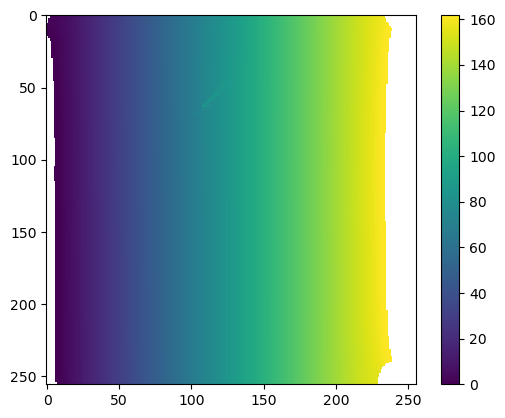

In [ ]:
plt.imshow(interpolated[:,:,1])
plt.colorbar()

In [ ]:
#| hide
#| notest

# prototyping code
field = interpolated[:,:,]

assert field.shape[0] == field.shape[1], "Input shape must be square"

field_shape = field.shape[2:]
uv_grid_steps = field.shape[0]

u, v = 2*[np.linspace(0,1, uv_grid_steps),]
U, V = np.meshgrid(u, v)

per_texture_vertex = interpolate.interpn((u, v), np.moveaxis(field, 1,0)[:,::-1], mesh.texture_vertices,
                                         method="linear", bounds_error=False)

matched_vertices = mesh.vertices[mesh.get_vertex_to_texture_vertex_indices()]

(np.nanmean(np.linalg.norm(per_texture_vertex - matched_vertices, axis=-1))
 /np.nanmean(np.linalg.norm(per_texture_vertex, axis=-1)))

0.00019437404876876028

In [ ]:
#| export

def interpolate_UV_to_per_vertex_field(mesh, field, domain="per-vertex"):
    """
    Interpolate a field defined by gridded values across UV square onto mesh vertices.
    
    This is useful for downstream geometric analysis. For example, you compute
    a vector field on a grid of the UV square and now want to get its values
    at the mesh vertices for geometric analysis.
    
    There may be some np.nans at the mesh boundary!
    
    The result can be defined per texture-vertex or per 3D-vertex. Make sure you use the right option!
        
    Parameters
    ----------
    mesh : tcmesh.ObjMesh
        Input mesh with UV coordinates.
    field : np.array of shape (uv_grid_steps, uv_grid_steps,...)
        Input field. Can be an array with any number of axes (e.g. scalar or vector field).
        Must be defined on a square grid with uniform step size of the UV square.
    domain : "per-vertex" or "per-texture-vertex"
        Whether the result will be defined per-vertex or per texture vertex.
        If per-vertex, the values corresponding to all texture vertices that
        map to a vertex are averaged.

    Returns
    -------
    np.array of shape (n_vertices, ...)
        Field evaluated at mesh vertices.
            
    """
    assert field.shape[0] == field.shape[1], "Input shape must be square"

    uv_grid_steps = field.shape[0]
    u, v = 2*[np.linspace(0,1, uv_grid_steps),]
    U, V = np.meshgrid(u, v)
    per_texture_vertex = interpolate.interpn((u, v), np.moveaxis(field, 1,0)[:,::-1], mesh.texture_vertices,
                                             method="linear", bounds_error=False)
    if domain == "per-texture-vertex":
        return per_texture_vertex
    return mesh.map_per_texture_vertex_to_per_vertex(per_texture_vertex)

In [ ]:
#| export

def interpolate_volumetric_data_to_uv(image, interpolated_3d_positions, resolution):
    """ 
    Interpolate volumetric image data onto UV coordinate grid.
    
    Uses 3d positions corresponding to each UV grid point as computed by interpolate_per_vertex_field_to_UV.
    3d coordinates (in microns) are converted into image coordinates via the scaling factor.
    
    Parameters
    ----------
    image : 4d np.array
        Image, axis 0  is assumed to be the channel axis
    interpolated_3d_positions : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        3d positions across [0,1]^2 UV grid, with uniform step size. UV positions that don't correspond to 
        any value are set to np.nan.
    resolution : np.array of shape (3,)
        Resolution in pixels/microns for each of the three spatial axes.
        
    Returns
    -------
    interpolated_data : np.array of shape (n_channels, uv_grid_steps, uv_grid_steps)
        3d volumetric data interpolated onto UV grid.
    """
    x, y, z = [np.arange(ni) for ni in image.shape[1:]]
    interpolated_data = np.stack([interpolate.interpn((x, y, z), channel, interpolated_3d_positions/resolution,
                                  method="linear", bounds_error=False) for channel in image])
    
    return interpolated_data

In [ ]:
mesh = tcmesh.ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_uv.obj")
#mesh.texture_vertices[2355] -= .2 # trigger the fallback interpolation method by messing up UV map


  o basic_example_mesh_remeshed


In [ ]:
# first interpolation step 

uv_grid_steps = 256  # set UV grid size
uv_mask = ndimage.binary_erosion(get_uv_layout_mask_mask(mesh, uv_grid_steps=uv_grid_steps), iterations=3)

# this is our UV grid
u, v = 2*[np.linspace(0,1, uv_grid_steps),]
U, V = np.meshgrid(u, v)

interpolated_3d_positions = interpolate_per_vertex_field_to_UV(mesh, mesh.vertices, domain="per-vertex",
                                                               uv_grid_steps=uv_grid_steps, map_back=True)
interpolated_normals = interpolate_per_vertex_field_to_UV(mesh, mesh.normals, domain="per-vertex",
                                                          uv_grid_steps=uv_grid_steps, map_back=True)

In [ ]:
%%time

interpolated_3d_positions = interpolate_per_vertex_field_to_UV(mesh, mesh.vertices, domain="per-vertex",
                                                               uv_grid_steps=uv_grid_steps, map_back=True)
interpolated_normals = interpolate_per_vertex_field_to_UV(mesh, mesh.normals, domain="per-vertex",
                                                          uv_grid_steps=uv_grid_steps, map_back=True)

CPU times: user 228 ms, sys: 4.21 ms, total: 233 ms
Wall time: 146 ms


In [ ]:
np.linalg.norm(mesh.normals, axis=-1).min()

0.9694902988837123

In [ ]:
np.nanmin(np.linalg.norm(interpolated_normals, axis=-1))

0.953786333836412

<matplotlib.image.AxesImage>

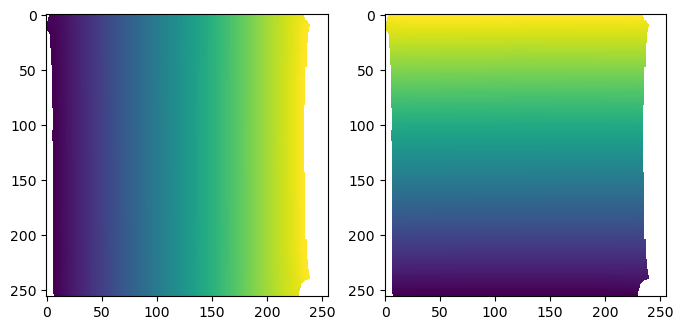

In [ ]:
# plot the interpolated positions
fig, (ax1, ax2) = plt.subplots(figsize=(8,4), ncols=2)

ax1.imshow(interpolated_3d_positions[...,1])
ax2.imshow(interpolated_3d_positions[...,2])

<matplotlib.image.AxesImage>

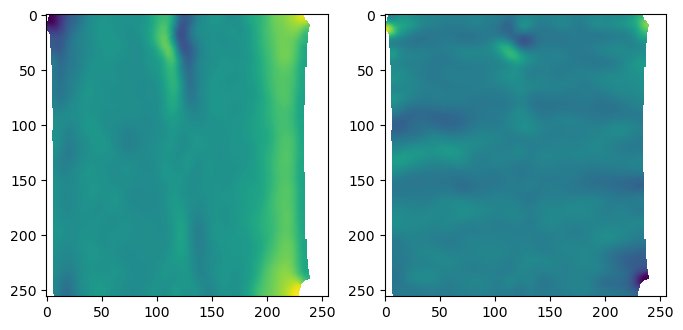

In [ ]:
# plot the interpolated normals
fig, (ax1, ax2) = plt.subplots(figsize=(8,4), ncols=2)

ax1.imshow(interpolated_normals[...,1])
ax2.imshow(interpolated_normals[...,2])

In [ ]:
#| export

def interpolate_volumetric_data_to_uv_multilayer(image, interpolated_3d_positions, interpolated_normals,
                                                 normal_offsets, resolution,):
    """ 
    Multilayer-interpolate volumetric image data onto UV coordinate grid.
    
    Uses 3d positions corresponding to each UV grid point as computed by interpolate_per_vertex_field_to_UV.
    3d coordinates (in microns) are converted into image coordinates via the scaling factor.
    
    Generates multiple "layers" by shifting surface along its normals.
    
    Parameters
    ----------
    image : 4d np.array
        Image, axis 0  is assumed to be the channel axis
    interpolated_3d_positions : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        3d positions across [0,1]^2 UV grid, with uniform step size. UV positions that don't correspond to 
        any value are set to np.nan.
    interpolated_normals : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        3d normals across [0,1]^2 UV grid, with uniform step size. UV positions that don't correspond to 
        any value are set to np.nan. Normal vectors will be automatically normalized.
    normal_offsets : np.array of shape (n_layers,)
        Offsets along normal direction, in same units as interpolated_3d_positions (i.e. microns).
        0 corresponds to no shift.
    resolution : np.array of shape (3,)
        Resolution in pixels/microns for each of the three spatial axes.
    
    Returns
    -------
    interpolated_data : np.array of shape (n_channels, n_layers, uv_grid_steps, uv_grid_steps)
        3d volumetric data multilayer-interpolated onto UV grid.
    
    """
    interpolated_normals = (interpolated_normals.T / np.linalg.norm(interpolated_normals, axis=-1).T).T
    interpolated_data = np.stack([interpolate_volumetric_data_to_uv(image,
                                  interpolated_3d_positions+o*interpolated_normals, resolution,)
                                  for o in normal_offsets], axis=1)
    return interpolated_data

In [ ]:
# second interpolation step. here we have to include the conversion factor from microns back to pixels

interpolated_data = interpolate_volumetric_data_to_uv(image, interpolated_3d_positions,
                                                      metadata_dict['resolution_in_microns'])

<matplotlib.colorbar.Colorbar>

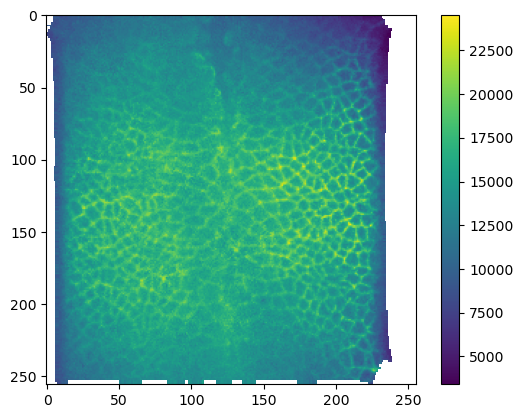

In [ ]:
plt.imshow(interpolated_data[1])
plt.colorbar()

In [ ]:
# now we can create a multilayer projection by  shifting the surface according to the vertex normals

normal_offsets = np.linspace(-2, 2, 5) # offset in microns

interpolated_data_multilayer = interpolate_volumetric_data_to_uv_multilayer(image,
                                                                 interpolated_3d_positions,
                                                                 interpolated_normals,
                                                                 normal_offsets,
                                                                 metadata_dict['resolution_in_microns'])
print("Shape: axis 0 is channel, axis 1 is normal offset", interpolated_data_multilayer.shape)

Shape: axis 0 is channel, axis 1 is normal offset (2, 5, 256, 256)


<matplotlib.colorbar.Colorbar>

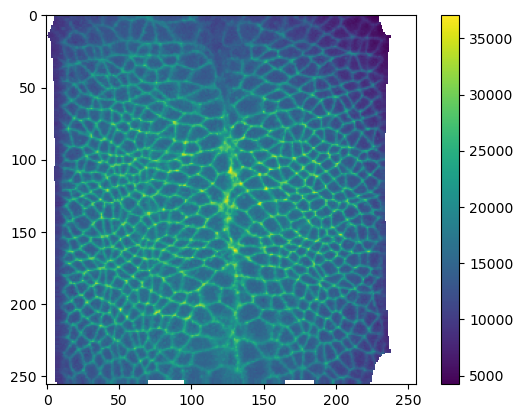

In [ ]:
plt.imshow(interpolated_data_multilayer[1, 0])
plt.colorbar()

#### Packaging it up

Let's package the interpolation workflow up into a single function.

In [ ]:
#| export

def create_cartographic_projections(image, mesh, resolution, normal_offsets=(0,), uv_grid_steps=256,
                                    map_back=True, use_fallback='auto'):
    """
    Create multilayer cartographic projections of an image using mesh.
    
    Computes multiple layers along the surface normal, with given normal offsets (in microns). 0 offset
    corresponds to no shift away from the mesh. Also computes 3d positions (in microns)
    and surface normals interpolated onto the UV grid.
    
    UV positions that don't correspond to any 3d position are set to np.nan.
    
    Parameters
    ----------
    image : str or 4d np.array
        Image, either as a path to a file or as an array. If array, axis 0  is assumed to be the channel axis
    mesh : str or tcmesh.ObjMesh
        Mesh, either as path to file, or as ObjMesh object.
    resolution : np.array of shape (3,)
        Image resolution in pixels/micron for the three spatial axes
    normal_offsets : np.array of float, optional
        Offsets along normal direction, in same units as interpolated_3d_positions (i.e. microns).
        0 corresponds to no shift.
    uv_grid_steps : int, default 256
        Size of UV grid. Determines resolution of result.
    map_back : bool, default True
        Map back the UV coordinates to [0,1]^2. Else, coordinates outside [0,1] are ignored.
    use_fallback : bool or 'auto', default 'auto'
        Ignore mesh connectivity when interpolating. This is to be used as a fallback
        if you have a UV map with lots of flipped triangles (i.e. self-intersections).
        If 'auto', the fallback option is chosen automatically if there are any flipped 
        triangles.
    
    Returns
    -------
    interpolated_data : np.array of shape (n_channels, n_layers, uv_grid_steps, uv_grid_steps)
        3d volumetric data multilayer-interpolated across [0,1]^2 UV grid, with uniform step size.
    interpolated_3d_positions : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        3d positions across [0,1]^2 UV grid, with uniform step size. 
    interpolated_normals : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        Normals across [0,1]^2 UV grid, with a uniform step size.
    """
    if isinstance(image, str):
        image = tcio.adjust_axis_order(tcio.imread(image))
    if isinstance(mesh, str):
        mesh = tcmesh.ObjMesh.read_obj(mesh)
    u, v = 2*[np.linspace(0,1, uv_grid_steps),]
    U, V = np.meshgrid(u, v)
    interpolated_3d_positions = interpolate_per_vertex_field_to_UV(mesh, mesh.vertices, domain="per-vertex",
                                                                   uv_grid_steps=uv_grid_steps,
                                                                   map_back=map_back, use_fallback=use_fallback)
    interpolated_normals = interpolate_per_vertex_field_to_UV(mesh, mesh.normals, domain="per-vertex",
                                                              uv_grid_steps=uv_grid_steps,
                                                              map_back=map_back, use_fallback=use_fallback)
    interpolated_data = interpolate_volumetric_data_to_uv_multilayer(image,
                                                                     interpolated_3d_positions,
                                                                     interpolated_normals, normal_offsets,
                                                                     resolution)
    return interpolated_data, interpolated_3d_positions, interpolated_normals 

In [ ]:
normal_offsets = np.linspace(-2, 2, 5) # in microns

In [ ]:
mesh = tcmesh.ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_uv.obj")
mesh.texture_vertices[2355] -= .2 # trigger the fallback interpolation method by messing up UV map


  o basic_example_mesh_remeshed


In [ ]:
projected_data, projected_coordinates, projected_normals = create_cartographic_projections(
    image=f"{metadata_dict['filename']}.tif",
    #mesh=f"{metadata_dict['filename']}_mesh_uv.obj",
    mesh=mesh,
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=256,
    use_fallback='auto')

/tmp/ipykernel_1939637/2667590714.py:49: RuntimeWarning: UV map has self-intersections, 3 flipped triangles. Try use_fallback=True?
  warnings.warn("UV map has self-intersections, {} flipped triangles. Try use_fallback=True?".format(
/tmp/ipykernel_1939637/2667590714.py:58: DeprecationWarning: Use of non-triangular meshes is discouraged
  warnings.warn("Use of non-triangular meshes is discouraged", DeprecationWarning)


In [ ]:
# let's add the normal offset we want to our metadata - it will be important for analysis!
metadata_dict["normal_offsets"] = normal_offsets

<matplotlib.colorbar.Colorbar>

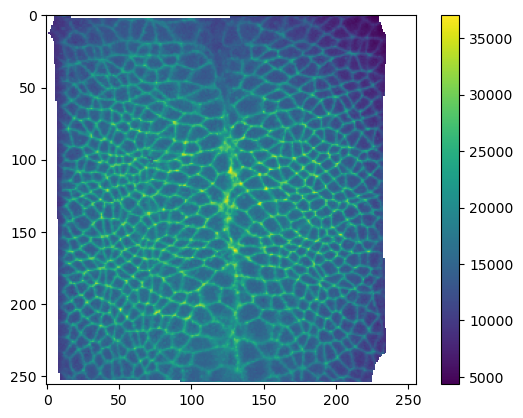

In [ ]:
plt.imshow(projected_data[1, 0])
plt.colorbar()

### Saving the results

We can now save the cartographic projections both as `.tif` stack for quantitative analysis and as `.png`'s for visualization as mesh texture in Blender. We will also save the metadata to a `.json` file

Annoyingly, we have to normalize our data and convert it to 8-bit to save it as png.

In [ ]:
# save metadata
tcio.save_dict_to_json(f"{metadata_dict['filename']}_metadata.json", metadata_dict)

In [ ]:
tcio.save_for_imageJ(f"{metadata_dict['filename']}_projected.tif", projected_data, z_axis=1)
tcio.save_for_imageJ(f"{metadata_dict['filename']}_3d_coordinates.tif", projected_coordinates)
tcio.save_for_imageJ(f"{metadata_dict['filename']}_normals.tif", projected_normals)

In [ ]:
texture_path = f"{os.getcwd()}/{metadata_dict['filename']}_textures"
tcio.save_stack_for_blender(projected_data, texture_path, normalization=(0.01, 0.99))

In [ ]:
# let's make a max projection of each channel and save them also

max_projected_ch_0, max_projected_ch_1 = projected_data.max(axis=1)
tcio.imsave(f'{texture_path}/max_channel_0.png', tcio.normalize_quantiles_for_png(max_projected_ch_0))
tcio.imsave(f'{texture_path}/max_channel_1.png', tcio.normalize_quantiles_for_png(max_projected_ch_1))

### Visualization in blender

You can set up textures in the "shading" tab:

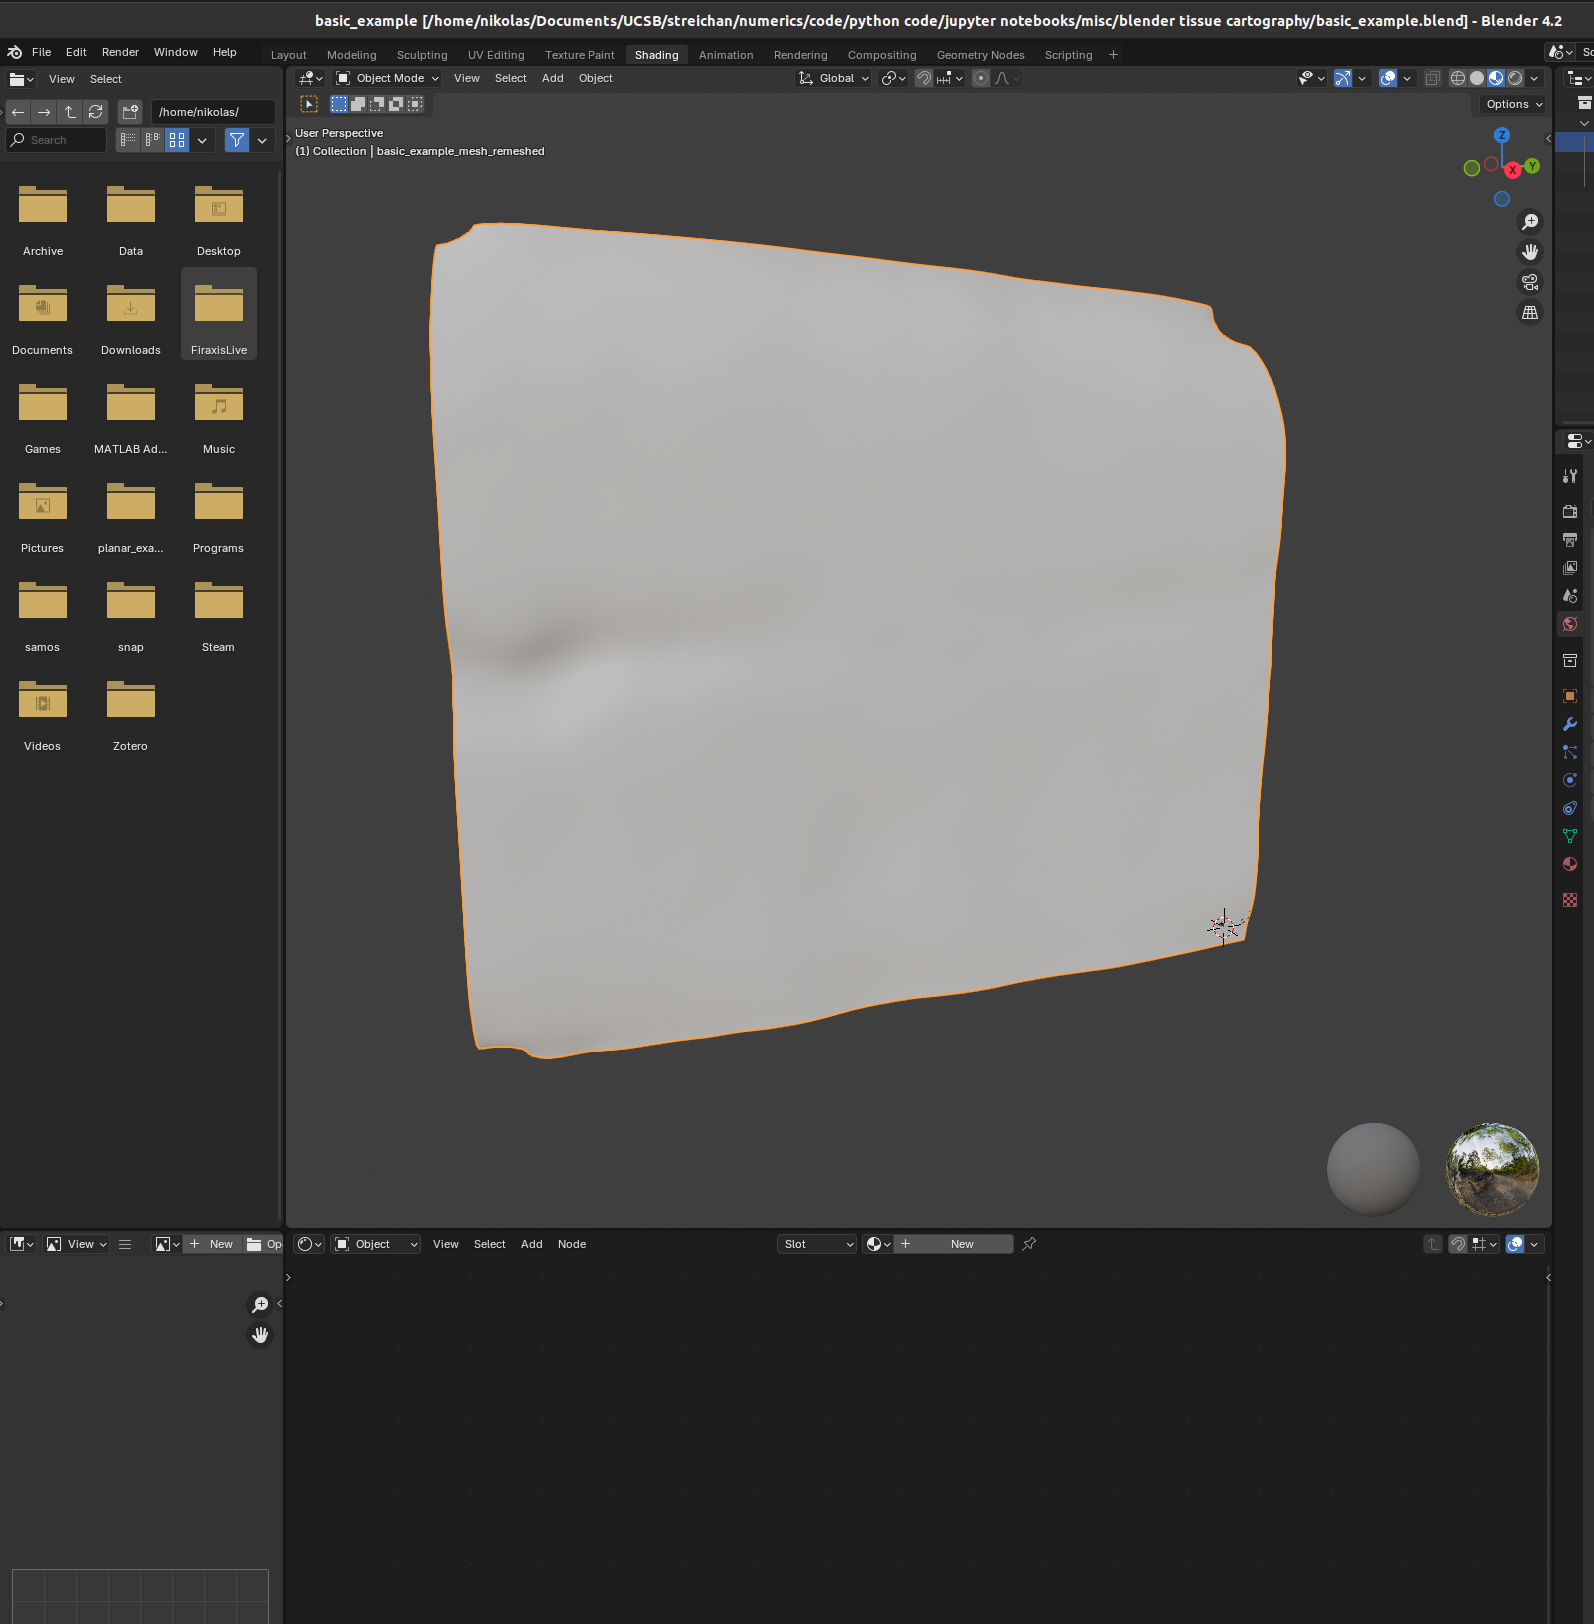

I find it helpful to remove the distracting "world" background, which you can do by either enabling "scene world" or setting "world opacity" to 0 in the viewport shading settings (arrow above "options" in the top right corner)

Go to the bottom panel, add a new material (center top of bottom panel), and press "shift+A" to add a new shader element (the search bar is very helpful). Here is an example configuration mixing two channels as red and green:

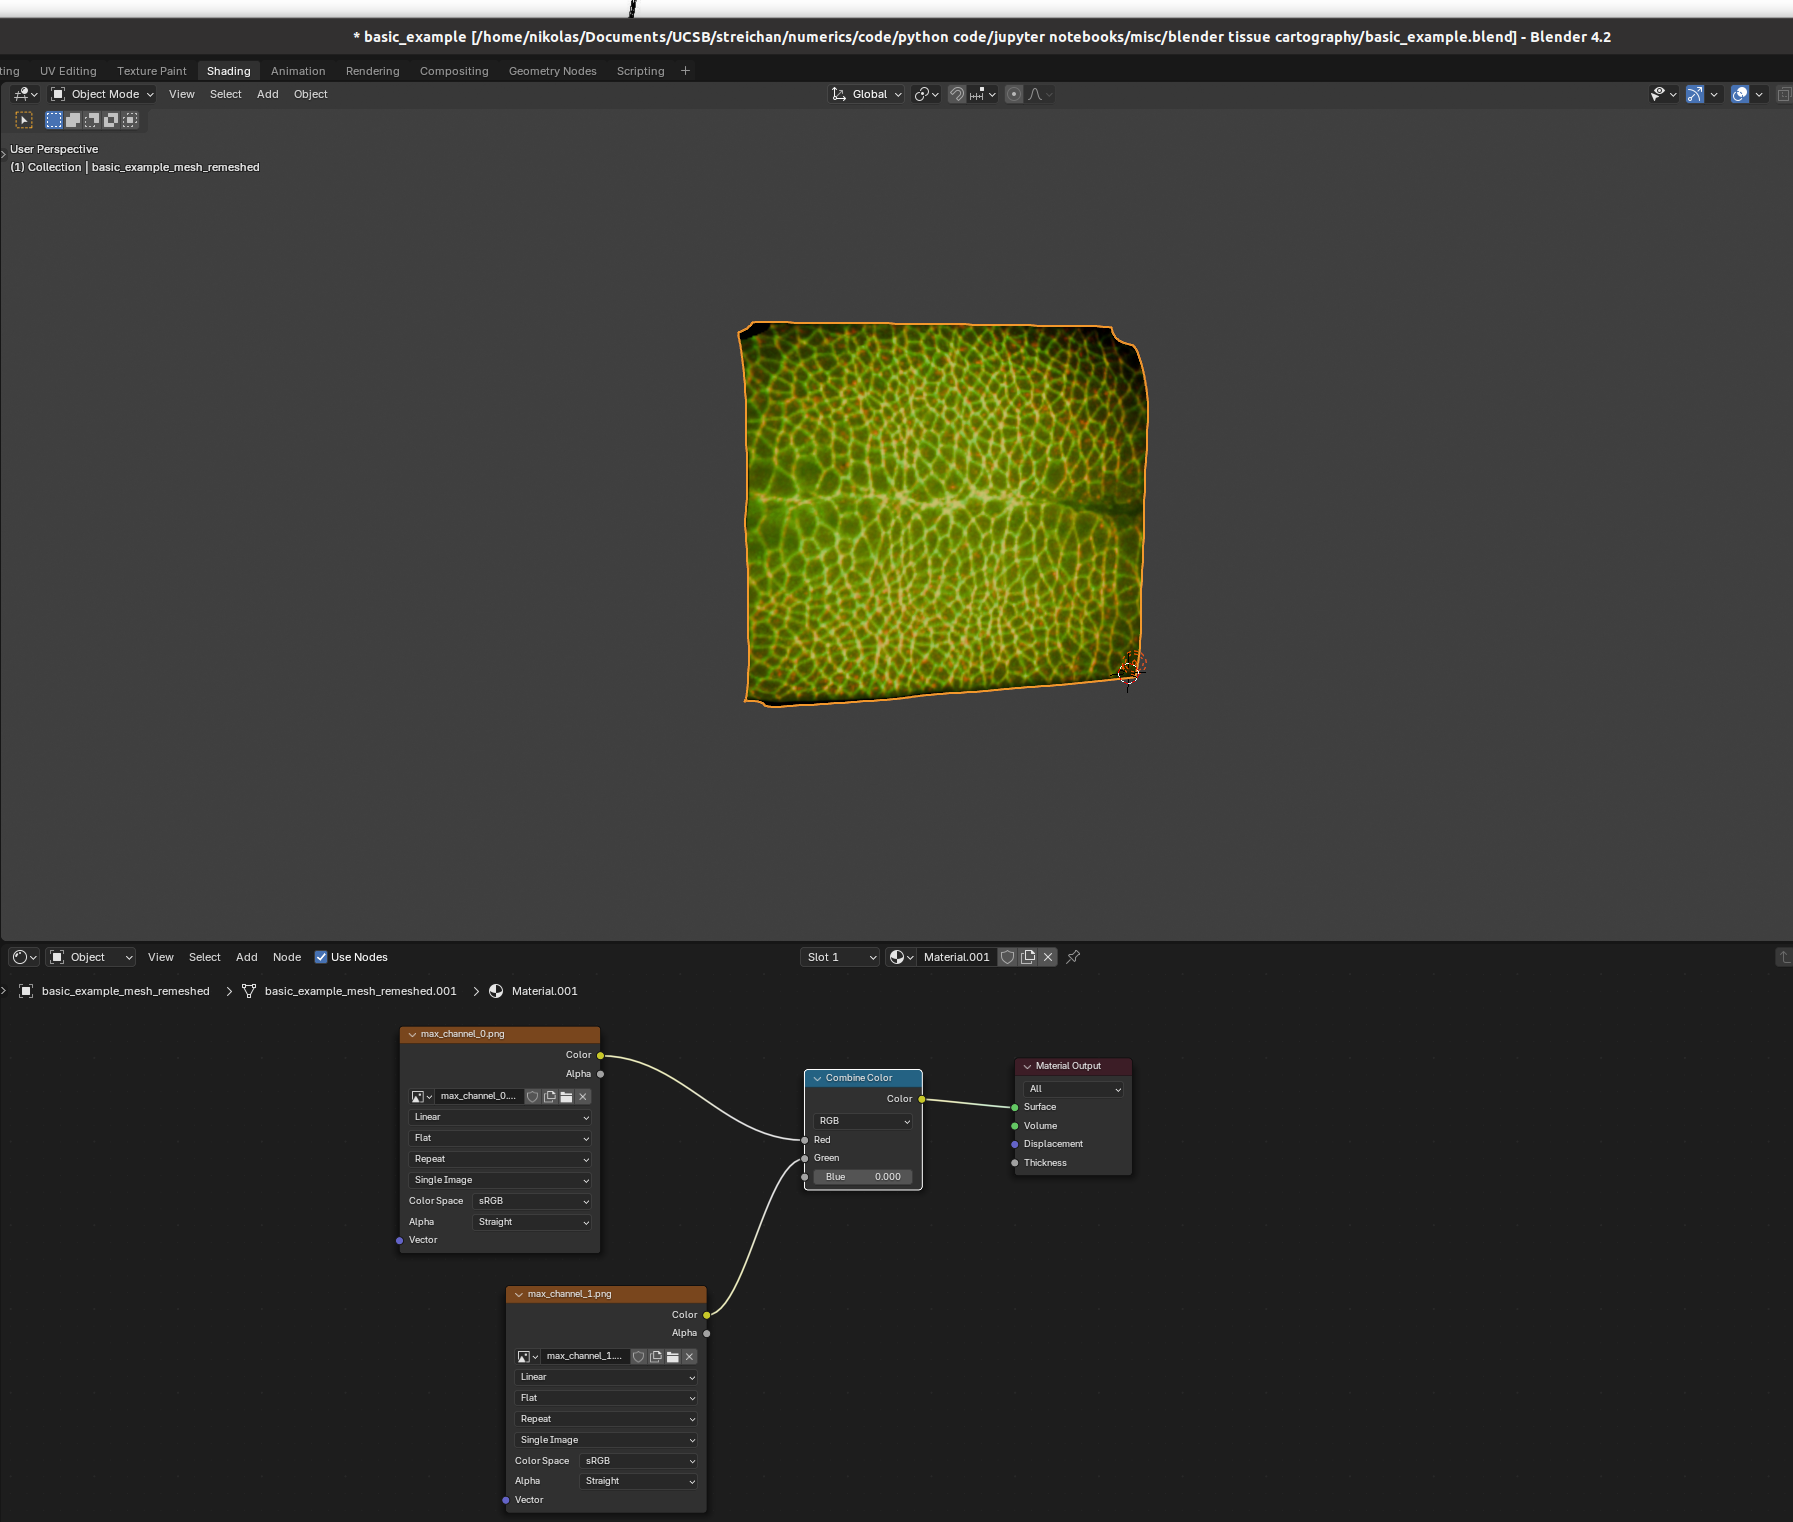

And there we go! Many further options exist to make more sophisticated renderings.